In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pylr2 import regress2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from src.data import spark_postgis
from src import constants

In [3]:
spark = spark_postgis.get_spark()

24/01/04 13:28:48 WARN Utils: Your hostname, sherwood resolves to a loopback address: 127.0.1.1; using 128.232.93.0 instead (on interface enp193s0f0np0)
24/01/04 13:28:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/ah2174/biomass-degradation/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ah2174/.ivy2/cache
The jars for the packages stored in: /home/ah2174/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
net.postgis#postgis-jdbc added as a dependency
net.postgis#postgis-geometry added as a dependency
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-020ae467-11fc-417e-9135-c1c1a5e656b9;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.3.1-incubating in central
	found org.locationtech.jts#jts-core;1.18.2 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.3.1-incubating in central
	found org.apache.sedona#sedona-common;1.3.1-incubating in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.3.1-incubating in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in central
	found org.data

24/01/04 13:28:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/01/04 13:28:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
def remove_duplicates(df, method="drop"):
    if method not in ("drop", "ignore"):
        raise ValueError("method must be either 'drop' or 'pick'")
    # If there are s1 duplicates, this means that two s2 shots
    # share the same pre-disturbance predictor. We follow the specified method
    # here: either remove one of them or just ignore the duplicates.
    print(
        "Found {} s1 duplicates".format(
            len(df[df.duplicated(subset=["t1_shot_number"])])
        )
    )
    if method == "drop":
        df = df.drop_duplicates(subset=["t1_shot_number"], keep="first")

    # If there are s2 duplicates, this means that two s1 shots can both be
    # used as predictors for the same s2 shot. In this case, it is safe to average
    # the two s1 shots together.
    print(
        "Found {} s2 duplicates".format(
            len(df[df.duplicated(subset=["t2_shot_number"])])
        )
    )
    # TODO: this won't exactly work -- only some of the columns can be averaged.
    df = df.groupby("t2_shot_number").mean().reset_index()
    return df

## A. Setup: Intact control

In [5]:
sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_neighbors_nau_test").as_posix())
sdf.createOrReplaceTempView("shots_table")
sdf = spark.sql("SELECT *, ST_GeomFromWKB(t1_geometry) AS t1_geom, ST_GeomFromWKB(t2_geometry) AS t2_geom FROM shots_table")
sdf = sdf.drop("t1_geometry", "t2_geometry")
print(sdf.count())
sdf.show(3)

4189899


+-----------------+------------------+--------------------+------------+--------------+------------------+-----------------+-----------------+--------------------+------------+--------------+------------------+-------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-------------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+------------------+----------------+-------------

In [6]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col

@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

sdf = sdf.withColumn("time_diff", (sdf["t2_absolute_time"] - sdf["t1_absolute_time"]))
sdf = sdf.withColumn("time_diff", get_days(col("time_diff")))

In [7]:
from pyspark.sql.functions import mean
sdf_filtered = sdf.filter(sdf.time_diff != 0)
agbd_df = sdf_filtered.sample(withReplacement=False, fraction=0.1).select("t1_agbd_a0", "t2_agbd_a0", "time_diff").toPandas()
rh98_df = sdf_filtered.sample(withReplacement=False, fraction=0.1).select("t1_rh_98_a0", "t2_rh_98_a0", "time_diff").toPandas()
rh50_df = sdf_filtered.sample(withReplacement=False, fraction=0.1).select("t1_rh_50_a0", "t2_rh_50_a0", "time_diff").toPandas()
n = sdf_filtered.count()
print(n)
corr_agbd = sdf_filtered.corr('t1_agbd_a0', 't2_agbd_a0')
sdf = sdf.withColumn("agbd_diff", (sdf.t2_agbd_a0 - sdf.t1_agbd_a0))
bias_agbd = (sdf_filtered
                .withColumn("agbd_diff", (sdf.t2_agbd_a0 - sdf.t1_agbd_a0))
                .select(mean('agbd_diff'))
                .collect())[0]['avg(agbd_diff)']
corr_rh98 = sdf_filtered.corr('t1_rh_98_a0', 't2_rh_98_a0')
bias_rh98 = (sdf_filtered
                .withColumn("rh98_diff", (sdf.t2_rh_98_a0 - sdf.t1_rh_98_a0))
                .select(mean('rh98_diff'))
                .collect())[0]['avg(rh98_diff)']
print(bias_agbd)
print(bias_rh98)


4185566


-3.8303394136109796
-0.13868818691373855


## B. Setup: Disturbance (GLAD)

In [8]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_glad_0d").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
glad_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
glad_df.loc[glad_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
glad_df.loc[glad_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(glad_df))
print(len(glad_df[glad_df["sample_grp"] == "treatment"]))
print(len(glad_df[glad_df["sample_grp"] == "control"]))
control_df = remove_duplicates(glad_df[glad_df["sample_grp"] == "control"])
control_df["sample_grp"] = "control"
treatment_df = remove_duplicates(glad_df[glad_df["sample_grp"] == "treatment"])
treatment_df["sample_grp"] = "treatment"
glad_df = pd.concat([control_df, treatment_df])
print(len(glad_df))
print(len(glad_df[glad_df["sample_grp"] == "treatment"]))
print(len(glad_df[glad_df["sample_grp"] == "control"]))
control_n = len(glad_df[glad_df["sample_grp"] == "control"])

102728
17944
84784
Found 8862 s1 duplicates
Found 10785 s2 duplicates
Found 1649 s1 duplicates
Found 2555 s2 duplicates
78877
13740
65137


In [9]:
control_df = glad_df[glad_df["sample_grp"] == "control"]
control_agbd_corr = control_df.t1_agbd_a0.corr(control_df.t2_agbd_a0)
control_agbd_bias = (control_df.t2_agbd_a0 - control_df.t1_agbd_a0).mean()
control_rh98_corr = control_df.t1_rh_98_a0.corr(control_df.t2_rh_98_a0)
control_rh98_bias = (control_df.t2_rh_98_a0 - control_df.t1_rh_98_a0).mean()
control_rh50_corr = control_df.t1_rh_50_a0.corr(control_df.t2_rh_50_a0)
control_rh50_bias = (control_df.t2_rh_50_a0 - control_df.t1_rh_50_a0).mean()
print("Control AGBD bias, corr: {},{}".format(control_agbd_bias, control_agbd_corr))
print("Control RH98 bias, corr: {},{}".format(control_rh98_bias, control_rh98_corr))
print("Control RH50 bias, corr: {},{}".format(control_rh50_bias, control_rh50_corr))
print("Mean t1 AGBD: {}".format(control_df.t1_agbd_a0.mean()))
print("Percent AGBD bias: {:.1f}%".format(control_agbd_bias / control_df.t1_agbd_a0.mean() * 100))
del control_df

Control AGBD bias, corr: -6.767540182847256,0.49889528314289006
Control RH98 bias, corr: -0.2632008010874982,0.6721483062029721
Control RH50 bias, corr: -0.2816493780964497,0.6415515879707981
Mean t1 AGBD: 148.38134180035917
Percent AGBD bias: -4.6%


## C. Setup: Disturbance (AFC)

In [10]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_afc_2022").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
afc_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
afc_df.loc[afc_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
afc_df.loc[afc_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(afc_df))
print(len(afc_df[afc_df["sample_grp"] == "treatment"]))
print(len(afc_df[afc_df["sample_grp"] == "control"]))
control_df = remove_duplicates(afc_df[afc_df["sample_grp"] == "control"])
control_df["sample_grp"] = "control"
treatment_df = remove_duplicates(afc_df[afc_df["sample_grp"] == "treatment"])
treatment_df["sample_grp"] = "treatment"
afc_df = pd.concat([control_df, treatment_df])
print(len(afc_df))
print(len(afc_df[afc_df["sample_grp"] == "treatment"]))
print(len(afc_df[afc_df["sample_grp"] == "control"]))


58753
3983
54770
Found 5996 s1 duplicates
Found 7265 s2 duplicates
Found 295 s1 duplicates
Found 487 s2 duplicates
44710
3201
41509


In [11]:
control_df = afc_df[afc_df["sample_grp"] == "control"]
control_agbd_corr = control_df.t1_agbd_a0.corr(control_df.t2_agbd_a0)
control_agbd_bias = (control_df.t2_agbd_a0 - control_df.t1_agbd_a0).mean()
control_rh98_corr = control_df.t1_rh_98_a0.corr(control_df.t2_rh_98_a0)
control_rh98_bias = (control_df.t2_rh_98_a0 - control_df.t1_rh_98_a0).mean()
control_rh50_corr = control_df.t1_rh_50_a0.corr(control_df.t2_rh_50_a0)
control_rh50_bias = (control_df.t2_rh_50_a0 - control_df.t1_rh_50_a0).mean()
print("Control AGBD bias, corr: {},{}".format(control_agbd_bias, control_agbd_corr))
print("Control RH98 bias, corr: {},{}".format(control_rh98_bias, control_rh98_corr))
print("Control RH50 bias, corr: {},{}".format(control_rh50_bias, control_rh50_corr))
print("Mean t1 AGBD: {}".format(control_df.t1_agbd_a0.mean()))
print("Percent AGBD bias: {:.1f}%".format(control_agbd_bias / control_df.t1_agbd_a0.mean() * 100))
del control_df

Control AGBD bias, corr: -5.621105662415681,0.45210882786011636
Control RH98 bias, corr: -0.0847467465866209,0.6391126278523951
Control RH50 bias, corr: -0.19172789414323654,0.5796446060699384
Mean t1 AGBD: 179.41249861021535
Percent AGBD bias: -3.1%


## 1. Control groups

Text(0.5, 0.98, 'Disturbed forest control (65,137 shot pairs)')

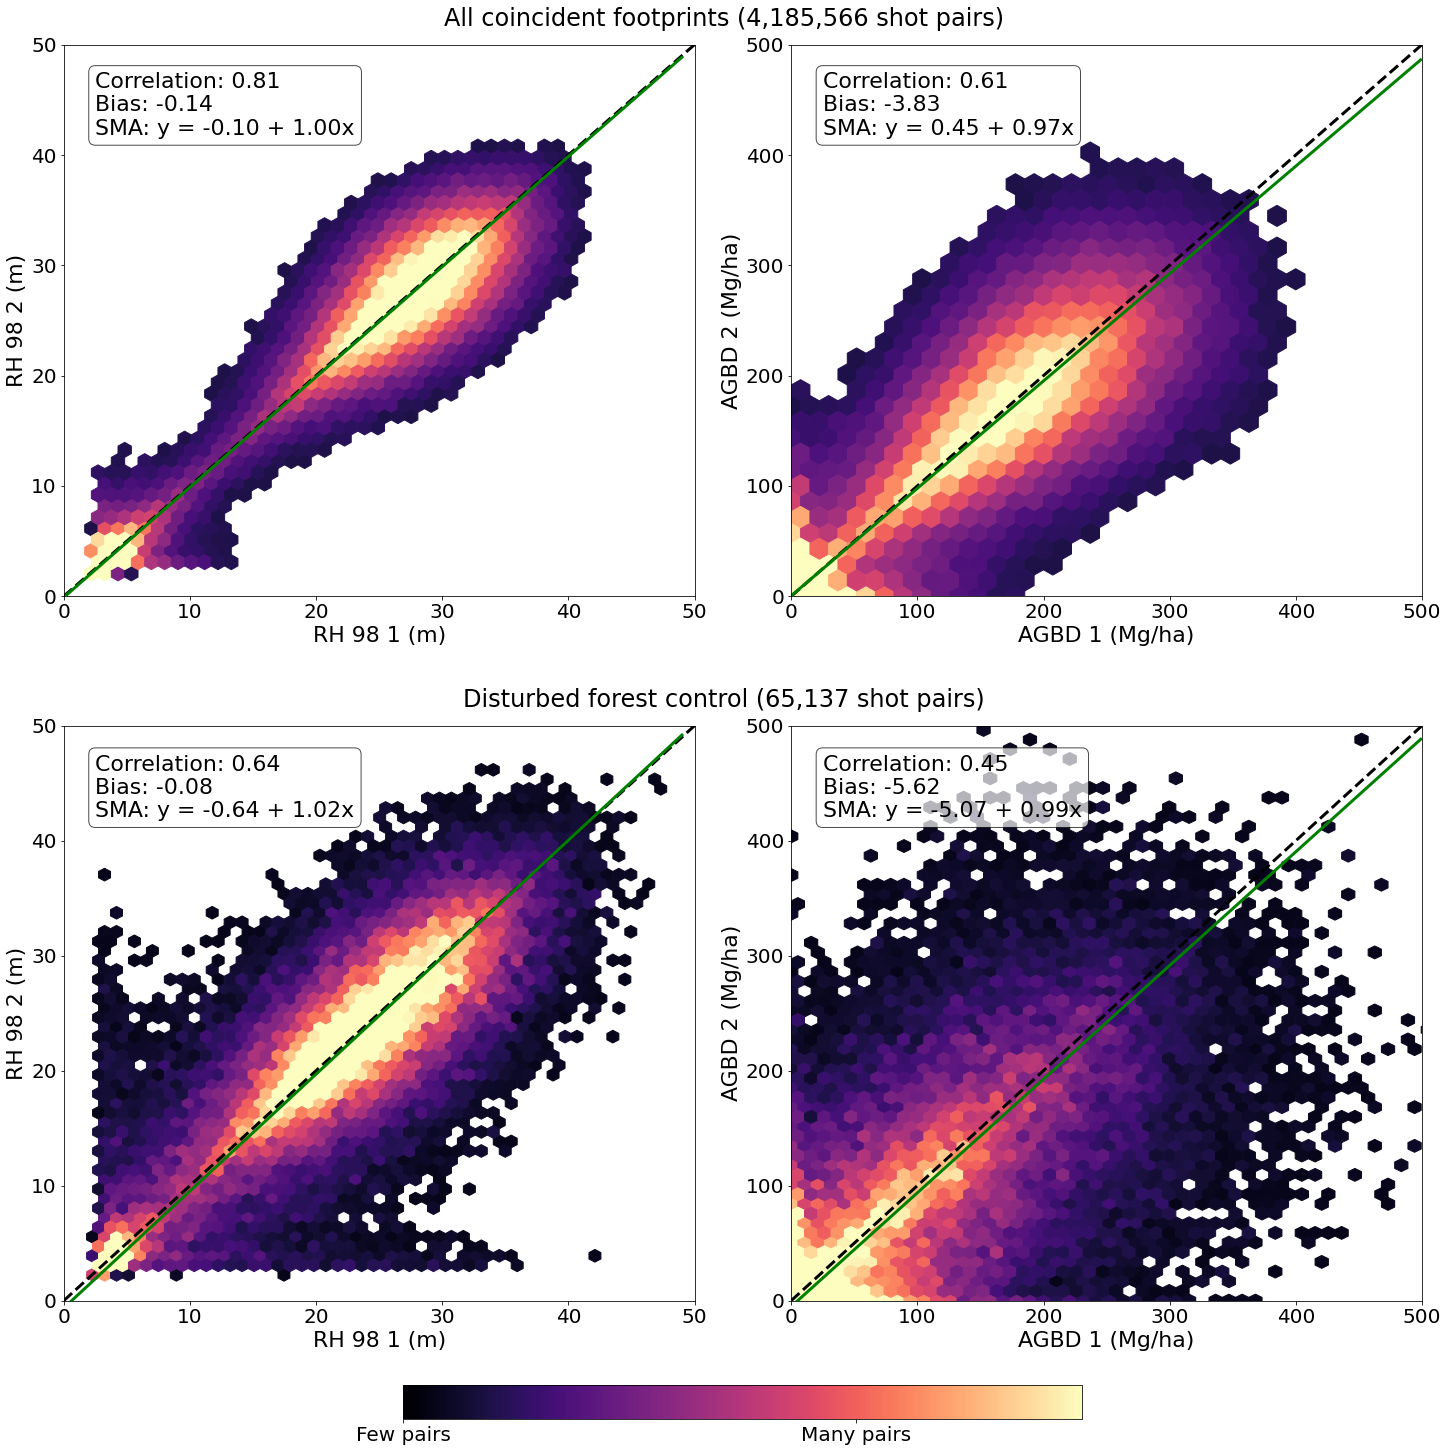

In [33]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fig = plt.figure(layout='constrained', figsize=(20, 20))
subfigs = fig.subfigures(2, 1, hspace=0.05, height_ratios=[0.85, 1])
axs_top = subfigs[0].subplots(1, 2)
axs_bottom = subfigs[1].subplots(1, 2)

axi = axs_top[0]
xs = rh98_df.t1_rh_98_a0
ys = rh98_df.t2_rh_98_a0
axmax = 50

# increase gridsize for smaller hexagons
imi = axi.hexbin(xs, ys, gridsize=100, cmap='magma', vmin=0, vmax=1200, mincnt=150)
axi.axis([0, axmax, 0, axmax])
axi.plot([0, axmax], [0, axmax], color='black', linestyle='dashed', linewidth=3)
res = regress2(xs, ys, _method_type_2="reduced major axis")
dummy_xs = np.arange(axmax)
axi.plot(dummy_xs, res["intercept"] + res["slope"] * dummy_xs, color='green', linewidth=3)

# cb = fig.colorbar(imi, ax=axi, orientation='vertical')
# cb.ax.tick_params(rotation=275)
axi.set_xlabel("RH 98 1 (m)", fontsize=22)
axi.set_ylabel("RH 98 2 (m)", fontsize=22)
textstr = f"Correlation: {corr_rh98:.2f}\nBias: {bias_rh98:.2f}\nSMA: y = {res['intercept']:.2f} + {res['slope']:.2f}x"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
axi.text(0.05, 0.95, textstr, transform=axi.transAxes, fontsize=22,
        verticalalignment='top', bbox=props)

axi = axs_top[1]
xs = agbd_df.t1_agbd_a0
ys = agbd_df.t2_agbd_a0
axmax = 500

# increase gridsize for smaller hexagons
imi = axi.hexbin(xs, ys, gridsize=300, cmap='magma', vmin=0, vmax=1200, mincnt=150)
axi.axis([0, axmax, 0, axmax])
axi.plot([0, axmax], [0, axmax], color='black', linestyle='dashed', linewidth=3)
res = regress2(xs, ys, _method_type_2="reduced major axis")
dummy_xs = np.arange(axmax)
axi.plot(dummy_xs, res["intercept"] + res["slope"] * dummy_xs, color='green', linewidth=3)
axi.set_xlabel("AGBD 1 (Mg/ha)", fontsize=22)
axi.set_ylabel("AGBD 2 (Mg/ha)", fontsize=22)
textstr = f"Correlation: {corr_agbd:.2f}\nBias: {bias_agbd:.2f}\nSMA: y = {res['intercept']:.2f} + {res['slope']:.2f}x"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
axi.text(0.05, 0.95, textstr, transform=axi.transAxes, fontsize=22,
        verticalalignment='top', bbox=props)

subfigs[0].suptitle(f"All coincident footprints ({n:,} shot pairs)", fontsize=24)

axi = axs_bottom[0]
xs = glad_df[glad_df["sample_grp"] == "control"].t1_rh_98_a0
ys = glad_df[glad_df["sample_grp"] == "control"].t2_rh_98_a0
axmax = 50

# increase gridsize for smaller hexagons
imi = axi.hexbin(xs, ys, gridsize=100, cmap='magma', vmin=0, vmax=120, mincnt=6)
axi.axis([0, axmax, 0, axmax])
axi.plot([0, axmax], [0, axmax], color='black', linestyle='dashed', linewidth=3)
res = regress2(xs, ys, _method_type_2="reduced major axis")
dummy_xs = np.arange(axmax)
axi.plot(dummy_xs, res["intercept"] + res["slope"] * dummy_xs, color='green', linewidth=3)
cb = fig.colorbar(imi, ax=axs_bottom.ravel().tolist(), orientation='horizontal', ticks=[0, 80], shrink=0.5)
cb.ax.set_xticklabels(['Few pairs', 'Many pairs'])
axi.set_xlabel("RH 98 1 (m)", fontsize=22)
axi.set_ylabel("RH 98 2 (m)", fontsize=22)
textstr = f"Correlation: {control_rh98_corr:.2f}\nBias: {control_rh98_bias:.2f}\nSMA: y = {res['intercept']:.2f} + {res['slope']:.2f}x"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
axi.text(0.05, 0.95, textstr, transform=axi.transAxes, fontsize=22,
        verticalalignment='top', bbox=props)

axi = axs_bottom[1]
xs = glad_df[glad_df["sample_grp"] == "control"].t1_agbd_a0
ys = glad_df[glad_df["sample_grp"] == "control"].t2_agbd_a0
axmax = 500

# increase gridsize for smaller hexagons
imi = axi.hexbin(xs, ys, gridsize=300, cmap='magma', vmin=0, vmax=120, mincnt=6)
axi.axis([0, axmax, 0, axmax])
axi.plot([0, axmax], [0, axmax], color='black', linestyle='dashed', linewidth=3)
res = regress2(xs, ys, _method_type_2="reduced major axis")
dummy_xs = np.arange(axmax)
axi.plot(dummy_xs, res["intercept"] + res["slope"] * dummy_xs, color='green', linewidth=3)
axi.set_xlabel("AGBD 1 (Mg/ha)", fontsize=22)
axi.set_ylabel("AGBD 2 (Mg/ha)", fontsize=22)
textstr = f"Correlation: {control_agbd_corr:.2f}\nBias: {control_agbd_bias:.2f}\nSMA: y = {res['intercept']:.2f} + {res['slope']:.2f}x"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
axi.text(0.05, 0.95, textstr, transform=axi.transAxes, fontsize=22,
        verticalalignment='top', bbox=props)

subfigs[1].suptitle(f"Disturbed forest control ({control_n:,} shot pairs)", fontsize=24)

In [34]:
agbd_df["pct_diff"] = (agbd_df.t2_agbd_a0 - agbd_df.t1_agbd_a0) / (agbd_df.t1_agbd_a0 + 0.1) * 100
rh98_df["pct_diff"] = (rh98_df.t2_rh_98_a0 - rh98_df.t1_rh_98_a0) / (rh98_df.t1_rh_98_a0 + 0.1) * 100
rh50_df["pct_diff"] = (rh50_df.t2_rh_50_a0 - rh50_df.t1_rh_50_a0) / (rh50_df.t1_rh_50_a0 + 0.1) * 100
glad_df["pct_diff_agbd"] = (glad_df.t2_agbd_a0 - glad_df.t1_agbd_a0) / (glad_df.t1_agbd_a0 + 0.1) * 100
glad_df["pct_diff_rh98"] = (glad_df.t2_rh_98_a0 - glad_df.t1_rh_98_a0) / (glad_df.t1_rh_98_a0 + 0.1) * 100
glad_df["pct_diff_rh50"] = (glad_df.t2_rh_50_a0 - glad_df.t1_rh_50_a0) / (glad_df.t1_rh_50_a0 + 0.1) * 100
afc_df["pct_diff_agbd"] = (afc_df.t2_agbd_a0 - afc_df.t1_agbd_a0) / (afc_df.t1_agbd_a0 + 0.1) * 100
afc_df["pct_diff_rh98"] = (afc_df.t2_rh_98_a0 - afc_df.t1_rh_98_a0) / (afc_df.t1_rh_98_a0 + 0.1) * 100
afc_df["pct_diff_rh50"] = (afc_df.t2_rh_50_a0 - afc_df.t1_rh_50_a0) / (afc_df.t1_rh_50_a0 + 0.1) * 100

import pandas as pd
intact_df = pd.DataFrame({
    "AGBD": agbd_df.pct_diff,
    "RH 98": rh98_df.pct_diff,
    "RH 50": rh50_df.pct_diff,
    "Group": "All pairs",
})
big_df = pd.concat([intact_df, pd.DataFrame({
    "AGBD": glad_df[glad_df.sample_grp == "control"].pct_diff_agbd,
    "RH 98": glad_df[glad_df.sample_grp == "control"].pct_diff_rh98,
    "RH 50": glad_df[glad_df.sample_grp == "control"].pct_diff_rh50,
    "Group": "Disturbed forest\n(GLAD)",
}), pd.DataFrame({
    "AGBD": afc_df[afc_df.sample_grp == "control"].pct_diff_agbd,
    "RH 98": afc_df[afc_df.sample_grp == "control"].pct_diff_rh98,
    "RH 50": afc_df[afc_df.sample_grp == "control"].pct_diff_rh50,
    "Group": "Disturbed forest\n(AFC)",
})])
print(big_df)
print(len(agbd_df))
print(len(rh98_df))
print(len(glad_df[glad_df.sample_grp == "control"]))
print(len(afc_df[afc_df.sample_grp == "control"]))
print(len(big_df))
print(len(big_df[big_df["Group"] == "All pairs"]))
print(len(big_df[big_df["Group"] == "Disturbed forest\n(AFC)"]))
print(len(big_df[big_df["Group"] == "Disturbed forest\n(GLAD)"]))

             AGBD      RH 98       RH 50                    Group
0        0.000000 -17.522870  -68.894390                All pairs
1      -31.967004 -15.560873   -0.799416                All pairs
2       41.065809 -37.689969   -4.884319                All pairs
3      795.653096 -15.166374  -12.984724                All pairs
4      -63.714708  -3.162062  -95.117541                All pairs
...           ...        ...         ...                      ...
41504    7.326491 -11.502558   39.070832  Disturbed forest\n(AFC)
41505   80.028816  13.695551  -27.410206  Disturbed forest\n(AFC)
41506    0.000000  54.889591  531.578950  Disturbed forest\n(AFC)
41507    0.000000  56.439404  100.000015  Disturbed forest\n(AFC)
41508  -50.734153 -16.765719  -45.988261  Disturbed forest\n(AFC)

[526090 rows x 4 columns]
418219
419444
65137
41509
526090
419444
41509
65137


                           Group Metric       value
0                      All pairs   AGBD    0.000000
1                      All pairs   AGBD  -31.967004
2                      All pairs   AGBD   41.065809
3                      All pairs   AGBD  795.653096
4                      All pairs   AGBD  -63.714708
...                          ...    ...         ...
1578265  Disturbed forest\n(AFC)  RH 50   39.070832
1578266  Disturbed forest\n(AFC)  RH 50  -27.410206
1578267  Disturbed forest\n(AFC)  RH 50  531.578950
1578268  Disturbed forest\n(AFC)  RH 50  100.000015
1578269  Disturbed forest\n(AFC)  RH 50  -45.988261

[1578270 rows x 3 columns]
                                       25%        75%
Group                    Metric                      
All pairs                AGBD   -32.308347  42.383469
                         RH 50  -36.842103  28.276478
                         RH 98  -14.213021  15.708008
Disturbed forest\n(AFC)  AGBD   -41.889739  56.633202
                        

[None, None]

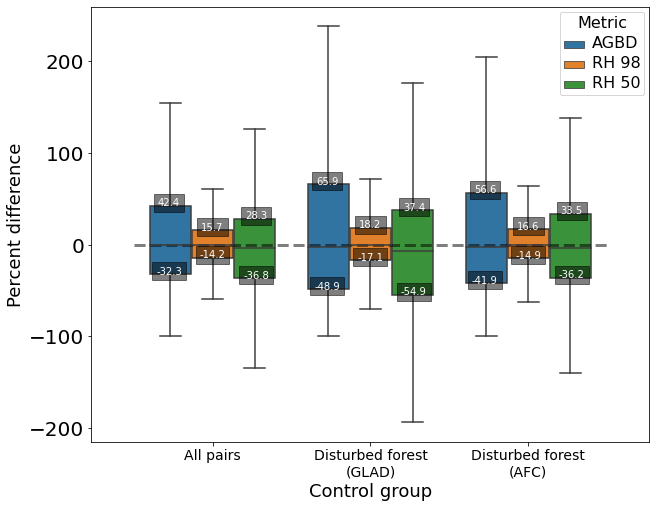

In [35]:
import seaborn as sns

dd=pd.melt(big_df,id_vars=['Group'],value_vars=['AGBD','RH 98', 'RH 50'], var_name='Metric')
print(dd)
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='Group',y='value', data=dd, hue='Metric', showfliers=False)

iqrs = dd.groupby(['Group','Metric']).describe()['value'][['25%','75%']]
print(iqrs)

# Add labels to the IQR
label_offset = 0.275     # unfortunately this needs to be adjusted manually
for iqr in iqrs.iterrows():
    name, metric = iqr[0]
    if 'All' in name:
        loc = 0
    if 'GLAD' in name:
        loc = 1
    if 'AFC' in name:
        loc = 2
    if 'AGBD' in metric:
        loc -= label_offset
    if '98' in metric:
        loc += 0
    if '50' in metric:
        loc += label_offset
    axs.text(loc, iqr[1][0], str(round(iqr[1][0],1)), color='white', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='black'), ha='center')
    axs.text(loc, iqr[1][1], str(round(iqr[1][1],1)), color='white', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='black'), ha='center')

axs.plot([-0.5, 2.5], [0, 0], color='black', linestyle='dashed', alpha = 0.5, linewidth = 3)
axs.set_xticklabels(axs.get_xticklabels(), fontsize=14)
axs.set_ylabel("Percent difference", fontsize=18)
axs.set_xlabel("Control group", fontsize=18)
plt.setp(axs.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(axs.get_legend().get_title(), fontsize='16') # for legend title

In [45]:
quantity = "rel_diff"
# Redo the above graph, but color by control group and have metric on the x-axis
agbd_df["Control Group"] = "All pairs"
rh98_df["Control Group"] = "All pairs"
rh50_df["Control Group"] = "All pairs"

glad_df["Control Group"] = "Disturbed forest (GLAD)"
glad_df_agbd = glad_df[glad_df.sample_grp == "control"].copy()[["t1_agbd_a0", "t2_agbd_a0", "Control Group"]]
glad_df_rh98 = glad_df[glad_df.sample_grp == "control"].copy()[["t1_rh_98_a0", "t2_rh_98_a0", "Control Group"]]
glad_df_rh50 = glad_df[glad_df.sample_grp == "control"].copy()[["t1_rh_50_a0", "t2_rh_50_a0", "Control Group"]]
print(len(glad_df_agbd))
print(len(glad_df_rh98))
print(len(glad_df_rh50))

afc_df["Control Group"] = "Disturbed forest (AFC)"
afc_df_agbd = afc_df[afc_df.sample_grp == "control"].copy()[["t1_agbd_a0", "t2_agbd_a0", "Control Group"]]
afc_df_rh98 = afc_df[afc_df.sample_grp == "control"].copy()[["t1_rh_98_a0", "t2_rh_98_a0", "Control Group"]]
afc_df_rh50 = afc_df[afc_df.sample_grp == "control"].copy()[["t1_rh_50_a0", "t2_rh_50_a0", "Control Group"]]
print(len(afc_df_agbd))
print(len(afc_df_rh98))
print(len(afc_df_rh50))

big_agbd_df = pd.concat([agbd_df, glad_df_agbd, afc_df_agbd])
big_rh98_df = pd.concat([rh98_df, glad_df_rh98, afc_df_rh98])
big_rh50_df = pd.concat([rh50_df, glad_df_rh50, afc_df_rh50])

big_agbd_df["rel_diff"] = (big_agbd_df.t2_agbd_a0 - big_agbd_df.t1_agbd_a0) / (big_agbd_df.t1_agbd_a0 + big_agbd_df.t2_agbd_a0)
big_rh98_df["rel_diff"] = (big_rh98_df.t2_rh_98_a0 - big_rh98_df.t1_rh_98_a0) / (big_rh98_df.t1_rh_98_a0 + big_rh98_df.t2_rh_98_a0)
big_rh50_df["rel_diff"] = (big_rh50_df.t2_rh_50_a0 - big_rh50_df.t1_rh_50_a0) / (big_rh50_df.t1_rh_50_a0 + big_rh50_df.t2_rh_50_a0)

big_agbd_df["pct_diff"] = (big_agbd_df.t2_agbd_a0 - big_agbd_df.t1_agbd_a0) / (big_agbd_df.t1_agbd_a0 + 0.1) * 100
big_rh98_df["pct_diff"] = (big_rh98_df.t2_rh_98_a0 - big_rh98_df.t1_rh_98_a0) / (big_rh98_df.t1_rh_98_a0 + 0.1) * 100
big_rh50_df["pct_diff"] = (big_rh50_df.t2_rh_50_a0 - big_rh50_df.t1_rh_50_a0) / (big_rh50_df.t1_rh_50_a0 + 0.1) * 100

big_agbd_df["Metric"] = "AGBD"
big_rh98_df["Metric"] = "RH 98"
big_rh50_df["Metric"] = "RH 50"

big_df = pd.concat([
    big_rh98_df[["Metric", "Control Group", quantity]],
    big_rh50_df[["Metric", "Control Group", quantity]],
    big_agbd_df[["Metric", "Control Group", quantity]],
])

print(big_df)

65137
65137
65137
41509
41509
41509
      Metric           Control Group  rel_diff
0      RH 98               All pairs -0.096400
1      RH 98               All pairs -0.084683
2      RH 98               All pairs -0.233083
3      RH 98               All pairs -0.082366
4      RH 98               All pairs -0.016736
...      ...                     ...       ...
41504   AGBD  Disturbed forest (AFC)  0.035356
41505   AGBD  Disturbed forest (AFC)  0.286012
41506   AGBD  Disturbed forest (AFC)       NaN
41507   AGBD  Disturbed forest (AFC)       NaN
41508   AGBD  Disturbed forest (AFC) -0.340074

[1575058 rows x 3 columns]


/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


                                     25%       75%
Control Group           Metric                    
All pairs               AGBD   -0.225205  0.205889
                        RH 50  -0.158900  0.150215
                        RH 98  -0.077127  0.073431
Disturbed forest (AFC)  AGBD   -0.269337  0.224073
                        RH 50  -0.192426  0.168940
                        RH 98  -0.081041  0.077112
Disturbed forest (GLAD) AGBD   -0.344881  0.264753
                        RH 50  -0.272825  0.219708
                        RH 98  -0.094093  0.083827


[None, None]

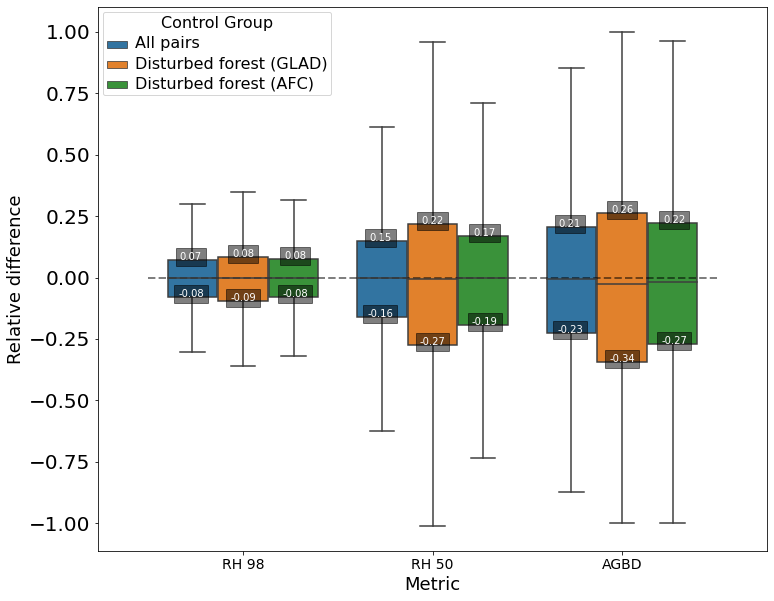

In [47]:
import seaborn as sns

# dd=pd.melt(big_df, id_vars=['Metric'], value_vars=['All pairs', 'Disturbed forest\n(RADD)', 'Disturbed forest\n(AFC)'], var_name='Group')
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
sns.boxplot(x='Metric',y=quantity, data=big_df, hue='Control Group', showfliers=False)

iqrs = big_df.groupby(['Control Group','Metric']).describe()[quantity][['25%','75%']]
print(iqrs)

# Add labels to the IQR
label_offset = 0.275     # unfortunately this needs to be adjusted manually
for iqr in iqrs.iterrows():
    name, metric = iqr[0]
    if 'RH 98' in metric:
        loc = 0
    if 'RH 50' in metric:
        loc = 1
    if 'AGBD' in metric:
        loc = 2
    if 'All' in name:
        loc -= label_offset
    if 'GLAD' in name:
        loc += 0
    if 'AFC' in name:
        loc += label_offset
    axs.text(loc, iqr[1][0], str(round(iqr[1][0],2)), color='white', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='black'), ha='center')
    axs.text(loc, iqr[1][1], str(round(iqr[1][1],2)), color='white', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='black'), ha='center')

axs.plot([-0.5, 2.5], [0, 0], color='black', linestyle='dashed', alpha = 0.5, linewidth = 2)
axs.set_xticklabels(axs.get_xticklabels(), fontsize=14)
if quantity == "rel_diff":
    axs.set_ylabel("Relative difference", fontsize=18)
elif quantity == "pct_diff":
    axs.set_ylabel("Percent difference", fontsize=18)
axs.set_xlabel("Metric", fontsize=18)
plt.setp(axs.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(axs.get_legend().get_title(), fontsize='16') # for legend title